<a href="https://colab.research.google.com/github/Nornalite/cnn_voice_recognition/blob/main/Syksy2024_projektitehtava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip
!pip install --upgrade keras
!pip install -U -q tensorflow
#!pip show keras


  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [2]:
# Nämä importattiin simple audio mallissa.
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display



In [3]:
import sys

import numpy as np
from keras import Model
from keras import Layer

def import_model(filepath: str) -> Model:
    """Load model from file"""
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')
print(model.summary())



Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_24 (Resizing)               │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_24 (Normalization)     │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,876,829 (18.60 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,251,218 (12.40 MB)

None


In [4]:
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:
    """Get layer weights from given model"""
    return model.get_layer(layer).get_weights()


def get_weights_shape(layer: list[np.ndarray]):
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)



In [5]:
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram



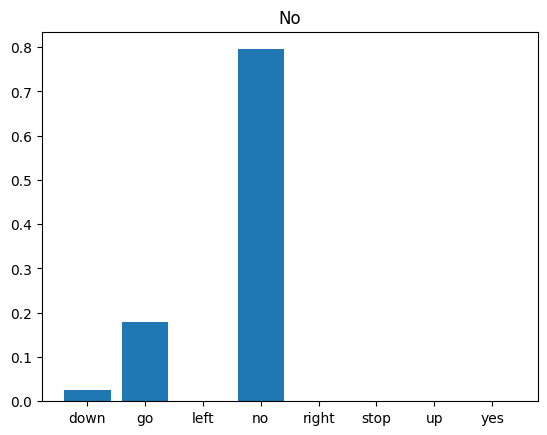

In [71]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)

audio_sample = x

waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [10]:
# Tekee lämpökartat kahdesta annetusta kuvasta
def compare_images(image1, title1, image2, title2):
  fig, axes = plt.subplots(1, 2, figsize=(18, 6))

  plt.subplot(1,2,1)
  axes[0].set_title(title1)
  i1 = np.array(image1).reshape((len(image1),len(image1[0])))
  sns.heatmap(i1)

  plt.subplot(1,2,2)
  axes[1].set_title(title2)
  i2 = np.array(image2).reshape((len(image2),len(image2[0])))
  sns.heatmap(i2)

  plt.show()

In [68]:
# Muunnetaan kaikki sisään otettu tavallisiksi Python-listoiksi koska tässä taloudessa ei käytetä mitään
# NumPyjä >:c

def generate_spectrogram(signal, sample_no, step, size):
  # vau, spektrogrammi
  result_length = int((len(signal) - sample_no) / step) + 1
  result = [0 for _ in range(result_length)]
  for i in range(result_length):
    segment = signal[int(i * step) : int(i * step + sample_no)] # joku pätkä signaalista
    result[i] = calculate_fourier(segment, size)
  print("Spektrogrammin mitat: ", len(result), len(result[0]), len(result[0][0]))
  return result

def calculate_fourier(signal, size):
  length = len(signal)
  frequencies = [[0 for _ in range(1)] for _ in range(size)] #jotain lievästi tuohon suuntaan
  for i in range(size):
    for j in range(length):
      frequencies[i][0] += signal[j]*(2.718282**(-1j*2*3.14159*i*j/length))
      #frequencies[i] += signal[j]*math.exp(-1j*2*3.14159*i*j/length)
    frequencies[i][0] = abs(frequencies[i][0])
  return frequencies


# Bilineaarinen interpolaatio: sovittaa vanhan kuvan päälle uuden kuvan ruudukon, nappaa uusiin
# pikseleihin arvon lähellä olevien vanhan kuvan pikseleiden keskiarvoista
def resize(data, width, height):
  result = [[[0 for _ in range(len(data[0][0]))] for _ in range(height)] for _ in range(width)]

  #Listojen suhteet
  ratio_x = len(data) / width
  ratio_y = len(data[0]) / height
  print("Suhteet: ", len(data), "/", width, " eli ", ratio_x, " ja ", len(data[0]), "/", height, " eli ", ratio_y)

  for i in range(width):
    for j in range(height):
      for k in range(len(data[0][0])):
        # Kullakin hetkellä laskettavan uuden pikselin keskipiste
        pos_x = ratio_x * (i + 0.5)
        pos_y = ratio_y * (j + 0.5)

        # Tarkistus täsmääkö uusi pikseli johonkin pikseliin alkuperäisessä kuvassa
        # Jos kyllä, otetaan vain arvo talteen
        if (pos_x % 1 == 0 and pos_y % 1 == 0):
          result[i][j][k] = data[int(ratio_x * i)][int(ratio_y * j)][k]
          continue

        # Pienempien pikselin indeksit ovat uuden pisteen x- ja y-koordinaattien takana, otetaan -0.5 taaksepäin
        # jottei vahingossa oteta pikseliä jonka keskikohta onkin viivan edessä (tämä taisi olla meidän suurin ongelmamme)
        low_x = int(pos_x - 0.5)
        low_y = int(pos_y - 0.5)

        # Tarkistus vastaako x-akseli jotain tasalinjaa
        # Jos ei
        if (pos_x % 1 != 0):
          # Edessä ja takana olevien pikselien indeksit talteen
          high_x = int(low_x + 1)
          # Etäisyydet ko. pikseleihin talteen
          len_x1 = pos_x - (low_x + 0.5)
          len_x2 = (high_x + 0.5) - pos_x
        else:
          # Tasalinjalla molemmat x:n arvot ovat samat, pituusarvoiksi laitetaan 0.5 niin että kahdesti
          # kertomalla tulisi sama lopputulos
          high_x = low_x
          len_x1 = 0.5
          len_x2 = 0.5

        # Tarkistus vastaako y-akseli jotain tasalinjaa
        # Jos ei
        if (pos_y % 1 != 0):
          # Edessä ja takana olevien pikselien indeksit talteen
          high_y = int(low_y + 1)
          # Etäisyydet ko. pikseleihin talteen
          len_y1 = pos_y - (low_y + 0.5)
          len_y2 = (high_y + 0.5) - pos_y
        else:
          # Tasalinjalla molemmat y:n arvot ovat samat, pituusarvoiksi laitetaan 0.5 niin että kahdesti
          # kertomalla tulisi sama lopputulos
          high_y = low_y
          len_y1 = 0.5
          len_y2 = 0.5

        # Kunkin vanhan pikselin arvo kerrottuna sitä vastakkaisella puolella olevan alueen koolla
        # (= lähellä oleva pikseli => isompi alue => isompi vaikutus lopulliseen arvoon)
        value = (data[low_x][low_y][k] * len_x2 * len_y2)
        value += (data[low_x][high_y][k] * len_x2 * len_y1)
        value += (data[high_x][low_y][k] * len_x1 * len_y2)
        value += (data[high_x][high_y][k] * len_x1 * len_y1)

        result[i][j][k] = value
  return result


# Muokkaa kuvaa niin, että arvot laskeutuvat tietylle alueelle(?)
def normalize(data, weights):
  result = [[[0 for _ in range(len(data[0][0]))] for _ in range(len(data[0]))] for _ in range(len(data))]

  for i in range(len(result)):
    for j in range(len(result[0])):
      for k in range(len(result[0][0])):
        result[i][j][k] += (data[i][j][k] - weights[0][0]) / (weights[1][0] ** 0.5)

  return result


# Kiertää kuva(t/n) läpi suodattim(i/e)lla, joka kohdalla kertoo kuvan pikselin arvon suodattimen senkohtaisella arvolla
def convolution(data, weights, bias):
  result = [[[0 for _ in range(len(weights[0][0][0]))] for _ in range(len(data[0])-2)] for _ in range(len(data)-2)]
  # Kuvan x-akseli
  for i in range(len(result)):
    # Kuvan y-akseli
    for j in range(len(result[0])):
      # Filtterien määrä
      for k in range(len(result[0][0])):
        total = 0
        # Kuvanipun paksuus
        for n in range(len(data[0][0])):
          # Filtterin x-akseli
          for l in range(len(weights)):
            # Filtterin y-akseli
            for m in range(len(weights[0])):
              total += data[i+l][j+m][n] * weights[l][m][n][k]
        total = total + bias[k]
        result[i][j][k] = total if total > 0 else 0

  return result


# Kiertää kuvan läpi neljän pikselin nipuissa, nappaa jokaisesta suurimman arvon uuteen kuvaan
def maxpool(data):
  print("muoto", len(data), " ", len(data[0]), " ", len(data[0][0]))

  result = [[[0 for _ in range(len(data[0][0]))] for _ in range(len(data[0])//2)] for _ in range(len(data)//2)]

  print(len(result), " ", len(result[0]), " ", len(result[0][0]))

  for i in range(0, len(data), 2):
    for j in range(0, len(data[0]), 2):
      for k in range (0, len(data[0][0])):
        max = data[i][j][k]
        max = data[i+1][j][k] if (max < data[i+1][j][k]) else max
        max = data[i][j+1][k] if (max < data[i][j+1][k]) else max
        max = data[i+1][j+1][k] if (max < data[i+1][j+1][k]) else max
        result[i//2][j//2][k] = max

  return result


# Muunnetaan kaikki sisään otettu tavallisiksi Python-listoiksi koska tässä taloudessa ei käytetä mitään
# NumPyjä >:c
def listify(thing):
  # Numpy-listat muunnetaan suoraan,
  if isinstance(thing, np.ndarray):
    result = thing.tolist()
  # Tensorit pitää aluksi muuntaa numpy-listoiksi jotta tolist() toimii
  elif isinstance(thing, tf.Tensor):
    if thing.shape[0] == 1:
      result = thing[0].numpy().tolist()
    else:
      result = thing.numpy().tolist()
  # Muissa tilanteissa luovutetaan
  else:
    result = thing

  return result


# Kuvanipun siivutus
def flatten(data):
  # Nippu tulee 3D-listana, joten otetaan sivujen pituus ja käytetään niitä kierrosmäärän ja
  # kokonaismäärän laskemiseen
  num = 0
  result = [0 for _ in range(len(data) * len(data[0]) * len(data[0][0]))]
  for i in range(len(data)):
    for j in range(len(data[0])):
      for k in range(len(data[0][0])):
        result[num] = data[i][j][k]
        num += 1
  return result


# Listojen keskenään kerronta
def matmul(data, weights, bias):
  # Luodaan oikean mittainen lista tuloksille (otetaan tässä painoarvojen kakkosriviltä, joka vastaa
  # seuraavan kierroksen neuronien määrää)
  result = [0 for _ in range(len(weights[1]))]

  # Jokaisen neuronin tulos: aiemman neuronikerroksen (data_array) tulokset kerrottuina painoilla, + lopussa bias päälle
  for i in range(len(weights[0])):
    dot_product = 0
    for j in range(len(weights)):
      dot_product += data[j] * weights[j][i]
    result[i] += bias[i] + dot_product

  return result


# Negatiivisten arvojen nollaus datassa
def relu(data):
  for i in range(len(data)):
    if data[i] < 0:
      data[i] = 0
  return data


# Neuronirivi 1 (relulla)
def dense1(data, weights, bias):
  result = matmul(data, weights, bias)
  result = relu(result)
  return result


# Neuronirivi 2 (ilman relua, lopputulokset)
def dense2(data, weights, bias):
  result = matmul(data, weights, bias)
  return result

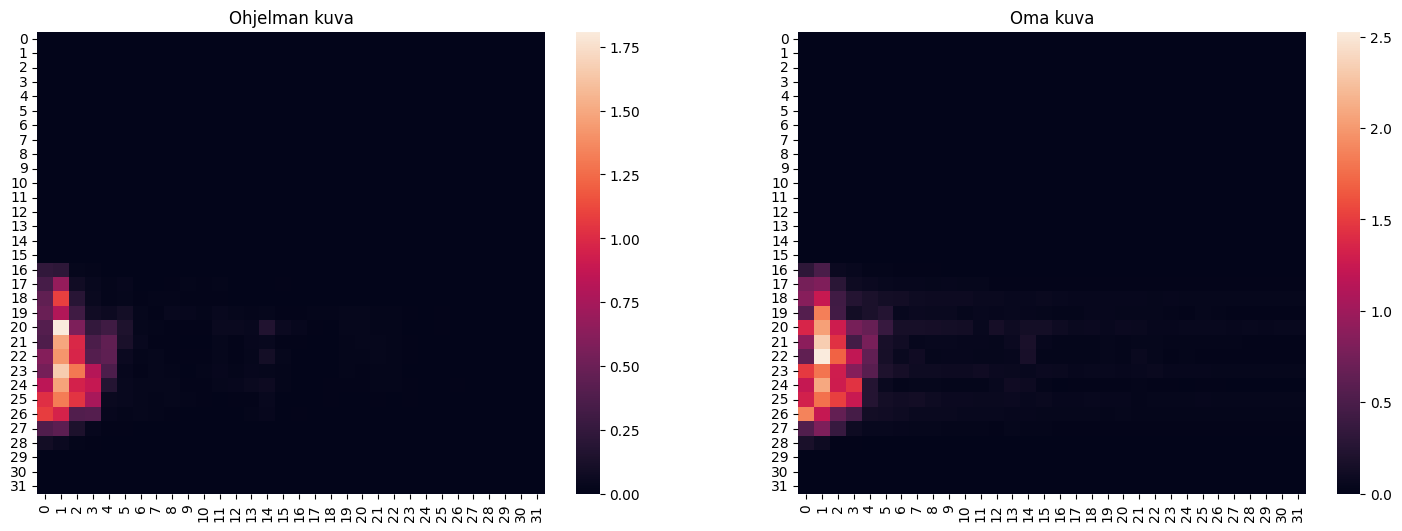

'\nprint("valmis tulos = ", layer_result)\nprint("oma tulos = ", layer_oma_result)\n\nplt.figure(1)\nplt.subplot(1,2,1)\nplt.bar(x_labels, tf.nn.softmax(layer_result[:]))\nplt.subplot(1,2,2)\nplt.bar(x_labels, tf.nn.softmax(layer_oma_result[:]))\nplt.show()\n'

In [77]:
(start, layer, end) = get_reference_layer("resizing_24", model)
norm_weights = listify(get_layer_weights("normalization_24", model))
conv_weights1 = listify(get_layer_weights("conv2d_48", model))
conv_weights2 = listify(get_layer_weights("conv2d_49", model))
weights1 = listify(get_layer_weights("dense_51",model))
weights2 = listify(get_layer_weights("dense_52",model))

'''
start_point = generate_spectrogram(listify(audio_sample), 255, 128, 129)

width = 32
height = 32
w0 = listify(norm_weights)
w1 = listify(conv_weights1[0])
b1 = listify(conv_weights1[1])
w2 = listify(conv_weights2[0])
b2 = listify(conv_weights2[1])
w3 = listify(weights1[0])
b3 = listify(weights1[1])
w4 = listify(weights2[0])
b4 = listify(weights2[1])

step0 = resize(start_point, width, height)
step1 = normalize(step0, w0)
step2 = convolution(step1, w1, b1)
step3 = convolution(step2, w2, b2)
step4 = maxpool(step3)
step5 = flatten(step4)
step6 = dense1(step5, w3, b3)
layer_oma_result = dense2(step6, w4, b4)
'''

# Lämpökartta koonvaihdon testaukseen, virallisella Resize()-kerroksella tehty testikuva
layer_result = listify(model(x))
true_spectrogram = listify(layer(start(x)))
compare_images(true_spectrogram, "Ohjelman kuva", step0, "Oma kuva")
'''
print("valmis tulos = ", layer_result)
print("oma tulos = ", layer_oma_result)

plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(layer_result[:]))
plt.subplot(1,2,2)
plt.bar(x_labels, tf.nn.softmax(layer_oma_result[:]))
plt.show()
'''